# Water flow in roots - Hybrid numerical scheme based on analytic solution in Pyhton

by Daniel Leitner, Felicien Meunier, Andrea Schnepf

In the following we will first describe the derivation of the numerical method (based on Meunier et al. ), the resulting Python code (available as single file at the CRootBox git repository), and finally we demonstrate Benchmark M31 and M32a,b.

## Numerical derivation

based on the analytical solution 

For constant $k_r$ and $k_z$ we can solve Eqn (5) yielding 
\begin{eqnarray}
\psi_r(z) := \psi_s + d_1 e^{\sqrt{c} z } + d_2 e^{-\sqrt{c} z} \label{analytic_flux}
\end{eqnarray} 
with 
\begin{eqnarray}
c = 2 a \pi k_r / k_z. 
\end{eqnarray} 
For two given pressures $\psi_1$, and $\psi_2$ at two nodes, the pressure in between $z \in [0,L]$ is $\psi_r(z)$ with the constants $d_1$, and $d_2$ calculated as:

\begin{align}
\left(\begin{array}{cc}
  1 & 1  \\
 \exp{(\sqrt{c} L)} & \exp{(-\sqrt{c} L)} \\
\end{array}\right)
\left(\begin{array}{c}
  d_{1}  \\
  d_{2}  \\
\end{array}\right)
{} &= 
\left(\begin{array}{c}  
  \psi_1-\psi_s \\
  \psi_2-\psi_s \\
\end{array}\right)
\end{align}

solving for $d_1$ and $d_2$ yields

\begin{align}
\left(\begin{array}{c}
  d_{1}  \\
  d_{2}  \\
\end{array}\right)
{} &= d^{-1}
\left(\begin{array}{cc}
  \exp{(-\sqrt{c} L)} & -1  \\
 -\exp{(\sqrt{c} L)} & 1 \\
\end{array}\right)
\left(\begin{array}{c}  
  \bar\psi_1 \\
  \bar\psi_2 \\
\end{array}\right),
\end{align}

with $\bar\psi_1 := \psi_1-\psi_s$, $\bar\psi_2 := \psi_2-\psi_s$, and 
\begin{align}
d = \exp{(-\sqrt{c} L)} - \exp{(\sqrt{c} L)}.
\end{align}

We will need the axial flux at $z=0$. 
\begin{align}
q_z &= - k_z \left( \frac{\partial \psi_r}{\partial z} + v_3 \right) \\
q_z &= - k_z \left( d_1 \sqrt{c} e^{\sqrt{c} z } - d_2 \sqrt{c} e^{-\sqrt{c} z}  + v_3 \right) \\
q_0 &= - k_z \left( d_1 \sqrt{c} - d_2 \sqrt{c} + v_3 \right) \\
\end{align}
where $v_3$ is the $z$-component of the normed xylem direction.

With 
\begin{align}
 d_{1} &= d^{-1}\exp{(-\sqrt{c} L)}\bar\psi_i  - d^{-1}\bar\psi_j  \\
 d_{2} &= -d^{-1}\exp{(\sqrt{c} L)}\bar\psi_i  + d^{-1}\bar\psi_j  \\
\end{align}
$q_0$ is written as  
\begin{align}
q_{ij,0} &= - k_z \left( d_1 \sqrt{c} - d_2 \sqrt{c} + v_3 \right) \\
q_{ij,0} &= - k_z \left( (\exp{(-\sqrt{c} L)}\bar\psi_i-\bar\psi_j) d^{-1} \sqrt{c} - (-\exp{(\sqrt{c} L)}\bar\psi_i + \bar\psi_j) d^{-1} \sqrt{c} + v_3 \right) \\
q_{ij,0} &= - k_z \left( d^{-1} \sqrt{c}\left( (\exp{(-\sqrt{c} L)}+\exp{(\sqrt{c} L)} ) \bar\psi_i - 2 \bar\psi_j \right) + v_3 \right) \\
\end{align}


Now in each node $i$ the summed fluxes have to equal to zero:
\begin{align}
\sum_{j \in N(i)} q_{ij} = 0
\end{align}
where N(i) are the indices of the segments $s_{i,j}$ starting from node $i$. Eqn 13 is written into a linear system for fixed $i$ and $j$

\begin{align}
c_{ii} \bar\psi_i + c_{ij} \bar\psi_j - b_i = 0 
\end{align}
with 
\begin{align}
c_{ii} &= k_z d^{-1} \sqrt{c} (\exp{(-\sqrt{c} L)}+\exp{(\sqrt{c} L)} ) \\
c_{ij} &= 2 k_z d^{-1} \sqrt{c} \\
 b_i &= k_z v_3 \\
\end{align}



(Not needed, just for fun) Furthermore, some additional calculations give the radial flux along the segment:
\begin{align}
q_r &= - 2 a \pi k_r (L\psi_s - \int_0^L \psi_r dz) \\
q_r &= \frac{2 a \pi k_r}{\sqrt{c}} ( d_1 e^{\sqrt{c} z } - d_2 e^{-\sqrt{c} z} ) \vert_{0}^{L} \\
q_r &= \frac{2 a \pi k_r}{\sqrt{c}} ( d_1 e^{\sqrt{c} L } - d_2 e^{-\sqrt{c} L} - d_1+ d_2 ) \\
\frac{q_r}{k_z} &= \sqrt{c} (d_1 (e^{\sqrt{c} L}-1) - d_2 (e^{-\sqrt{c} L}-1) )
\end{align}

and we can show that the equation for a segment which is zero by mass conservation is actually zero:
\begin{align}
0 &= (q_0 - q_L) + q_r \\
\frac{q_0 - q_L}{k_z} &= d_1 (\sqrt{c} -\sqrt{c} e^{\sqrt{c} L}) - d_2 (\sqrt{c} - \sqrt{c} e^{-\sqrt{c} L}) 
\end{align}
above actually adds up to zero. 

## Implementation in Python 

We start wtih some imports:

In [1]:
from math import *
import numpy as np
from numpy.linalg.linalg import norm
import matplotlib.pylab as plt
from scipy import sparse
import scipy.sparse.linalg as LA
from rsml_reader import * # located in the same directory 

### Creating the linear system 

The following code builds the linear system as described above. Therefore we loop over each segment $e_{ij}$, and add its share to the system (i.e. $c_{ii}, c_{ij}, c_{jj}, c_{ji}, b_{i}, b_{j}$)

The inputs are all parameters that are needed: 
* `seg`: numpy array ($N_s$,2) of segment indices [1]
* `nodes`: numpy array ($N$,3) of the node coordinates [L]
* `radius`: segment radii [L]
* `kr` radial conductivity for each segment [L2 T M−1] 
* `kz` axial conductivity for each segment [L5 T M-1]
* `rho` density of soil water [M L-3]
* `g` gravitational acceleration [L T−2]
* `soil_p` lambda function returning the soil matric potential at a given location, p=soil_p(x,y,z) [M L−1 T−2]
 
The output is the linear system $Qx=b$

In [2]:
def linear_system(seg, nodes, radius, kr, kz, rho, g, soil_p):
    
    Ns, N = seg.shape[0], nodes.shape[0]
    I,J = np.zeros(4*Ns, dtype = np.int64), np.zeros(4*Ns, dtype = np.int64)    
    V = np.zeros(4*Ns)
    b = np.zeros(N)        
    k = 0 # entry counter
    
    for s in range(0, Ns):        
        
        i,j = seg[s,0], seg[s,1]
        n1, n2 = nodes[i,:], nodes[j,:]
        mid = 0.5*(n1+n2)        
        p_s = soil_p(mid[0],mid[1],mid[2]) # evaluate soil matric potential
        v = n2-n1
        l = norm(v)        
        vz = v[2] / l # normed direction                
        a = radius[s]
        
        c = 2.*a*pi*kr[s]/kz[s] # Eqn (2)
        d = exp(-sqrt(c)*l)-exp(sqrt(c)*l) # Eqn (5)
        di = 1./d
        
        cii = -kz[s]*di*sqrt(c)*(exp(-sqrt(c)*l)+exp(sqrt(c)*l)) # Eqn 16
        cij = 2*kz[s]*di*sqrt(c)  # Eqn 17
        bi = kz[s]*rho*g*vz # Eqn 18
               
        b[i] += bi         
        I[k], J[k], V[k]  = i, i, cii
        k += 1                        
        I[k], J[k], V[k]  = i, j, cij
        k += 1         
        
        # edge ji
        i, j = j, i
        b[i] -= bi # Eqn 14 with changed sign        
        I[k], J[k], V[k]  = i, i, cii
        k += 1                          
        I[k], J[k], V[k]  = i, j, cij
        k += 1 
         
    Q = sparse.coo_matrix((V,(I,J)))    
    Q = sparse.csr_matrix(Q)     
    return (Q, b)

Modifies the linear system $Q, b$ to describe Diriclet boundary conditions at the node indices `n0` as described above.

Input parameter are 
* `n0`: node indices where to apply the boundary condition
* `d`: fixed potential at n0

In [3]:
def bc_dirichlet(Q, b, n0, d):
    c = 0
    for c in range(0, len(n0)):
        i = n0[c]          
        e0 = np.zeros((1,Q.shape[1])) # build zero vector
        Q[i,:] = sparse.csr_matrix(e0) # replace row i with ei
        Q[i,i] = 1
        b[i] = d[c]    
    return Q, b 

Modifies the linear system $Q, b$ to describe a Neumann boundary conditions at the node indices `n0` as described above.

Input parameter are 
* `n0`: node indices where to apply the boundary condition
* `f`: flux at n0

In [4]:
def bc_neumann(Q, b, n0, f):
    c = 0
    for c in range(0, len(n0)):                
        i = n0[c]  # print("Neumann BC at node "+str(i))       
        b[i] += f[c]        
    return Q, b 

## Benchmark 1 

We compare the Pyhton numerical implementation to the analytical solution. First, some additional definitions

In [5]:
g = 9.81                 # gravitational acceleration [m/s^2]
rho = 1.e3               # density of water, [kg/m^3]
ref = 1.e5               # reference pressure [kg/ (m s^2)]

def toPa(ph): # [cm] pressure head to Pascal [kg/ (m s^2)]
    return ref + ph / 100. * rho * g

def toHead(pa): # Pascal [kg/ (m s^2)] to [cm] pressure head
    return (pa-ref) * 100. / rho / g

Next we pick the parameters 

In [6]:
# Parameters
L = 0.5                          # length of single straight root [m]
a = 2.e-3                        # radius [m]
kz0 = 4.32e-2                    # [cm^3/day]
kz = 1e-6*kz0/(rho*g)/(24*3600)  # axial conductivity [m^5 s / kg] 
kr0 = 1.728e-4                   # [1/day]
kr = kr0/(rho*g)/(24* 3600)      # radial conductivity per root type [m^2 s / kg] 
p_s = toPa(-200)                 # static soil pressure [cm] 
p0 = toPa(-500)                 # dircichlet bc at top

First we recalculate the analytical solution (for later comparison)

In [7]:
# Analytical solution
c = 2*a*pi*kr/kz
p_r = lambda z: toHead( p_s + d[0]*exp(sqrt(c)*z) + d[1]*exp(-sqrt(c)*z) )
# Boundary conditions
AA = np.array([[1,1], [sqrt(c)*exp(-sqrt(c)*L), -sqrt(c)*exp(sqrt(c)*L)] ]) # dirichlet top, neumann bot
bb = np.array([p0-p_s, -rho*g]) #
d = np.linalg.solve(AA, bb) # compute constants d_1 and d_2 from bc
# Evaluate function
za_ = np.linspace(0,-L,100)
pr = list(map(p_r, za_))

For the numerical solution we first create a grid. nnz denotes the resolution.

In [8]:
nnz = 100
nodes = np.zeros((nnz,3))
seg = np.zeros(((nnz-1),2), dtype=int) 
c = 0
for i in range(1, nnz):
    seg[c,0] = i-1
    seg[c,1] = i
    c += 1    
    nodes[i,:] = [0.,0.,-i*L/(nnz-1)]

Next we copy the constant values to lists, so that we have a value per segment, and create a call back function for the soil matric potential.

In [9]:
kr_ = [kr] * (nnz-1)
kz_ = [kz] * (nnz-1)
a_ = [a] * (nnz-1)            
soil = lambda x,y,z : p_s # call back function for soil potential

Now we create the linear system, and apply the boundary conditions

In [10]:
Q, b = linear_system(seg, nodes, a_, kr_, kz_, rho, g, soil) #  
Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0-p_s])) # dirichlet top
Q, b = bc_neumann(Q, b, [nnz-1], [0]) # neumann bot
x = LA.spsolve(Q, b, use_umfpack = True) # direct
x = x+p_s

And, the result:

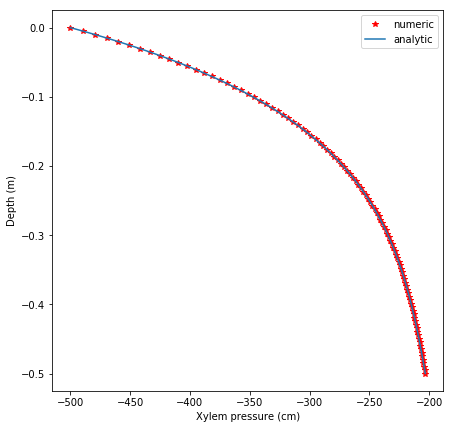

In [11]:
fig=plt.figure(figsize=(7, 7))
plt.plot(list(map(toHead, x)),za_,"r*")
plt.plot(pr,za_)
plt.xlabel("Xylem pressure (cm)")
plt.ylabel("Depth (m)")
plt.legend(["numeric", "analytic"])
plt.show()
# for automatic evalutation
np.savetxt("root_water_flow/M31/python_hybrid", np.vstack((100*za_,list(map(toHead, x)))),delimiter=',')

## Benchmark 2


The benchmark is given by a static small root system, static conductivities, a predefined pressure (-1000 cm) at the root collar, and no-flux at the root tips.

In [12]:
simtime = 14 # [day]
polylines, props, funcs = read_rsml("root_grid/RootSystem.rsml") # in rmsl.py located in the same directory 
nodes, segs = get_segments(polylines, props) # in rmsl.py located in the same directory      
nodes = np.array(nodes)*1.e-3 # [mm] -> [m], and convert from list to numpy array
segs = np.array(segs, dtype = np.int64) # convert from list to numpy array 
radii, cts, types = get_parameter(polylines, funcs, props)
radii = np.array(radii)*1.e-3 # [mm]->[m] 
age = 14 - np.array(cts) # [day]<

We prepare the parameters to use the aboves numerical scheme, and create the linear system:

In [13]:
# Parameters
kx0 = 4.32e-2                    # [cm^3/day]
kx = 1e-6*kz0/(rho*g)/(24*3600)  # axial conductivity [m^5 s / kg] 
kr0 = 1.728e-4                   # [1/day]kr = kr0/(rho*g)/(24* 3600)      # radial conductivity per root type -> [m^2 s / kg]
kx_ = [kx] * (len(age))
kr_ = [kr] * (len(age))
p_s = toPa(-200)                 # [cm]->[Pa]
soil = lambda x,y,z : p_s        # [cm] pressure head
rho = 1.e3                       # [kg/m^3]
g = 9.81                         # [m/s^2]
#  Create linear system
Q, b = linear_system(segs, nodes, radii, kr_, kx_, rho, g, soil) 

Next, we need to set the boundary conditions by modifying the linear system:

In [14]:
tips = [len(polylines[0])-1] # calculate tip indices
for p in polylines[1:]:
    tips.append(tips[-1]+1+len(p)-1)

p0 = toPa(-500) # [cm]->[Pa], pressure at root collar 

Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0-p_s])) # Dirichlet top
# Q, b = bc_neumann(Q, b, np.array(tips), np.zeros(len(tips))) # Neumann at tips

Finally, we can solve the system

In [15]:
x = LA.spsolve(Q, b, use_umfpack = True) # direct
x += p_s
x = toHead(x)

qz = -kx*((x[1]-x[0])/0.001-rho*g) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
qr = -0.001*2*pi*radii[0]*1.e-2*kr*(p_s-x[0]) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
print("net collar flux is", qr+qz, "mm^3/day; ", "axial", qz, ", radial", qr) 

net collar flux is 29.182970204850815 mm^3/day;  axial 29.33335151844578 , radial -0.1503813135949661


and plot the final result:

from  -500.0 to -240.81577634724258  cm pressure head


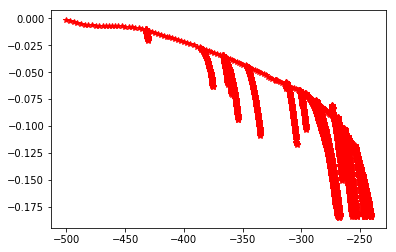

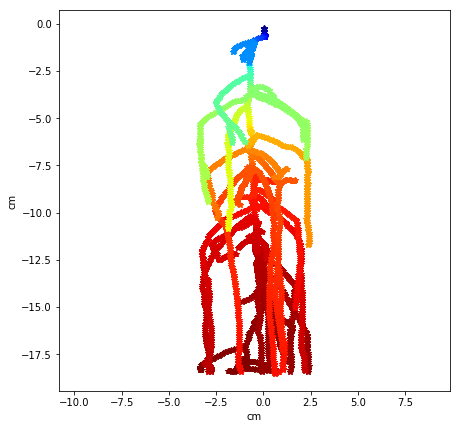

In [16]:
xmin, xmax = min(x), max(x)
print("from ", xmin, "to", xmax, " cm pressure head")
# Plot
plt.plot(x, nodes[:,2], "r*")
plt.show()

fig=plt.figure(figsize=(7, 7))
y_ = []
x_ = []
for i,s in enumerate(segs): 
    n = 0.5*(nodes[s[0]]+nodes[s[1]]) # mid point
    c = (x[s[0]]-xmin)/(xmax-xmin)
    plt.plot([n[0]*100, n[0]*100], [n[2]*100, n[2]*100], "*", color = plt.cm.jet(c))    
    nn=n[2]*100;
    y_.append(nn) # todo 
    x_.append(x[s[0]])
plt.axis('equal')
plt.xlabel("cm")
plt.ylabel("cm")
plt.show()

# Save file
np.savetxt("root_water_flow/M32a/python_hybrid", np.vstack((y_,x_)),delimiter=',')

## Benchmark 3


Same as before but with age depending conductivities:

In [17]:
from scipy import interpolate

kx0 = np.array([[0,6.74E-02],[2,7.48E-02],[4,8.30E-02],[6,9.21E-02],[8,1.02E-01],[10,1.13E-01],[12,1.26E-01],[14,1.40E-01],[16,1.55E-01],[18,1.72E-01],[20,1.91E-01],[22,2.12E-01],[24,2.35E-01],[26,2.61E-01],[28,2.90E-01],[30,3.21E-01],[32,3.57E-01]])
kr0 = np.array([[0,1.14E-03],[2,1.09E-03],[4,1.03E-03],[6,9.83E-04],[8,9.35E-04],[10,8.90E-04],[12,8.47E-04],[14,8.06E-04],[16,7.67E-04],[18,7.30E-04],[20,6.95E-04],[22,6.62E-04],[24,6.30E-04],[26,5.99E-04],[28,5.70E-04],[30,5.43E-04],[32,5.17E-04]])
kx1 = np.array([[0,4.07E-04],[1,5.00E-04],[2,6.15E-04],[3,7.56E-04],[4,9.30E-04],[5,1.14E-03],[6,1.41E-03],[7,1.73E-03],[8,2.12E-03],[9,2.61E-03],[10,3.21E-03],[11,3.95E-03],[12,4.86E-03],[13,5.97E-03],[14,7.34E-03],[15,9.03E-03],[16,1.11E-02],[17,1.36E-02]])
kr1 = np.array([[0,4.11E-03],[1,3.89E-03],[2,3.67E-03],[3,3.47E-03],[4,3.28E-03],[5,3.10E-03],[6,2.93E-03],[7,2.77E-03],[8,2.62E-03],[9,2.48E-03],[10,2.34E-03],[11,2.21E-03],[12,2.09E-03],[13,1.98E-03],[14,1.87E-03],[15,1.77E-03],[16,1.67E-03],[17,1.58E-03]])
kx0_ = interpolate.interp1d(kx0[:,0], kx0[:,1]) # ,assume_sorted=False
kr0_ = interpolate.interp1d(kr0[:,0], kr0[:,1],assume_sorted=False)
kx1_ = interpolate.interp1d(kx1[:,0], kx1[:,1], fill_value = 1.36E-02, bounds_error = False)
kr1_ = interpolate.interp1d(kr1[:,0], kr1[:,1], fill_value = 1.58E-03, bounds_error = False)

kx_ = np.zeros(len(segs))
kr_ = np.zeros(len(segs))
for i in range(0, len(segs)):
    if types[i]==1:
        kx_[i] = kx0_(age[i]) /(24*3600) /1e6/ (rho*g)
        kr_[i] = kr0_(age[i]) /(24*3600) / (rho*g)      
    else:
        kx_[i] = kx1_(age[i]) /(24*3600) /1e6/ (rho*g)
        kr_[i] = kr1_(age[i]) /(24*3600) / (rho*g)
    
#  Create linear system
Q, b = linear_system(segs, nodes, radii, kr_, kx_, rho, g, soil) 

# BC
p0 = toPa(-500) # cm->Pa, pressure at root collar 
Q, b = bc_dirichlet(Q, b, np.array([0]), np.array([p0-p_s])) # dirichlet top
Q, b = bc_neumann(Q, b, np.array(tips), np.zeros(len(tips))) # neumann at tips

x = LA.spsolve(Q, b, use_umfpack = True) # direct
x += p_s
x = toHead(x)

qz = -kx_[0]*((x[1]-x[0])/0.001-rho*g) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
qr = -0.001*2*pi*radii[0]*1.e-2*kr1*(p_s-x[0]) *24*3600*1e9 # m^3 s^-1 -> mm^3 day^-1 
# print("net collar flux is", qr+qz, "mm^3/day; ", "axial", qz, ", radial", qr) 
print("done.")

done.


from  -500.0 to -198.8638646049659  cm pressure head


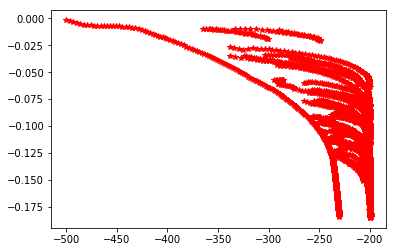

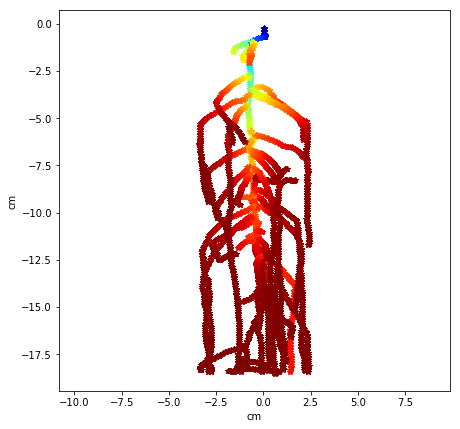

In [18]:
xmin = min(x)
xmax = max(x)
print("from ", xmin, "to", xmax, " cm pressure head")
# Plot
plt.plot(x, nodes[:,2], "r*")
plt.show()

fig=plt.figure(figsize=(7, 7))
y_ = []
x_ = []
for i,s in enumerate(segs): 
    n = 0.5*(nodes[s[0]]+nodes[s[1]]) # mid point
    c = (x[s[0]]-xmin)/(xmax-xmin)
    plt.plot([n[0]*100, n[0]*100], [n[2]*100, n[2]*100], "*", color = plt.cm.jet(c))  
    nn=n[2]*100;
    y_.append(nn) # todo     
    x_.append(x[s[0]])
plt.axis('equal')
plt.xlabel("cm")
plt.ylabel("cm")
plt.show()

# Save file
np.savetxt("root_water_flow/M32b/python_hybrid", np.vstack((y_,x_)),delimiter=',')

## References

Schnepf, A., Leitner, D., Landl, M., Lobet, G., Mai, T.H., Morandage S., Sheng, C., Zoerner, M., Vanderborght, J., Vereecken, H. (2018) CRootBox: a structural-functional modelling framework for root systems. *Annals of Botany*, 121 (5), 1033-1053
